In [5]:
import pickle
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from bayesian_torch.layers import LinearReparameterization
from bayesian_torch.layers import LinearFlipout

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

print('TORCH VERSION : ', torch.__version__)

TORCH VERSION :  1.10.1+cu102


## Data pre-processing

In [7]:
# load in the emulator training data
df = pickle.load(open('emulator_train_data.pkl', 'rb'))
print(df.shape)
print(df.columns)
df.head()

(600, 7)
Index(['c60_flow', 'sultine_flow', 'T', 'NA', 'MA', 'BA', 'TA'], dtype='object')


,c60_flow,sultine_flow,T,NA,MA,BA,TA
0,73.777013,139.862987,141.15,0.000000,0.123069,0.493082,0.383849
1,47.975387,29.864613,134.75,0.032046,0.700855,0.232875,0.034224
2,146.751920,80.888080,115.85,0.144684,0.763265,0.085645,0.006406
3,21.782227,17.137773,147.50,0.011557,0.587944,0.327834,0.072665
4,63.006720,44.513280,101.70,0.160928,0.762194,0.072458,0.004420


In [12]:
# make train and test split
np.random.seed(42)
df_shuffled = df.sample(frac=1)

train_dataset = df_shuffled.iloc[:500, :]
test_dataset = df_shuffled.iloc[500:, :]

train_features = train_dataset.loc[:, ['c60_flow', 'sultine_flow', 'T']].values
test_features = test_dataset.loc[:, ['c60_flow', 'sultine_flow', 'T']].values

train_targets = train_dataset.loc[:, ['NA', 'MA', 'BA', 'TA']].values
test_targets = test_dataset.loc[:, ['NA', 'MA', 'BA', 'TA']].values

print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(500, 3) (500, 4)
(100, 3) (100, 4)


In [14]:
# scale the featues using minmax
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_features)
_train_features = torch.tensor(feature_scaler.transform(train_features)).float()
_test_features = torch.tensor(feature_scaler.transform(test_features)).float()

_train_targets = torch.tensor(train_targets).float()
_test_targets = torch.tensor(test_targets).float()

print(_train_features.shape, _test_features.shape)
print(_train_targets.shape, _test_targets.shape)

# make a batch loader
ds_train = torch.utils.data.TensorDataset(_train_features, _train_targets)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(_test_features, _test_targets)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)


torch.Size([500, 3]) torch.Size([100, 3])
torch.Size([500, 4]) torch.Size([100, 4])


In [16]:
# helper function for stats
def evaluate(true, pred):
    stats = {}
    # na, 0th index
    mse = mean_squared_error(true[:, 0], pred[:, 0])
    rmse = np.sqrt(mean_squared_error(true[:, 0], pred[:, 0]))
    r2 = r2_score(true[:, 0], pred[:, 0])
    pear = pearsonr(true[:, 0], pred[:, 0])[0]
    
    stats['na'] = {'mse': mse, 'rmse': rmse, 'r2': r2, 'pear': pear}
    
    # ma, 1st index
    mse = mean_squared_error(true[:, 1], pred[:, 1])
    rmse = np.sqrt(mean_squared_error(true[:, 1], pred[:, 1]))
    r2 = r2_score(true[:, 1], pred[:, 1])
    pear = pearsonr(true[:, 1], pred[:, 1])[0]
    
    stats['ma'] = {'mse': mse, 'rmse': rmse, 'r2': r2, 'pear': pear}
    
    # ba, 2nd index
    mse = mean_squared_error(true[:, 2], pred[:, 2])
    rmse = np.sqrt(mean_squared_error(true[:, 2], pred[:, 2]))
    r2 = r2_score(true[:, 2], pred[:, 2])
    pear = pearsonr(true[:, 2], pred[:, 2])[0]
    
    stats['ba'] = {'mse': mse, 'rmse': rmse, 'r2': r2, 'pear': pear}
    
    # ta, 3rd index
    mse = mean_squared_error(true[:, 3], pred[:, 3])
    rmse = np.sqrt(mean_squared_error(true[:, 3], pred[:, 3]))
    r2 = r2_score(true[:, 3], pred[:, 3])
    pear = pearsonr(true[:, 3], pred[:, 3])[0]
    
    stats['ta'] = {'mse': mse, 'rmse': rmse, 'r2': r2, 'pear': pear}
    
    return stats

## Build the BNN

In [9]:
prior_mu = 0.0
prior_sigma = 1.0
posterior_mu_init = 0.0
posterior_rho_init = -2.0

prior_mu = 0.0
prior_sigma = 1.0
posterior_mu_init = 0.0
posterior_rho_init = -2.0

class BayesianNetwork(nn.Module):
    def __init__(self, x_dim=3, y_dim=4, hidden_dim=64):
        super(BayesianNetwork, self).__init__()
        
        self.blinear1 = LinearReparameterization(
                in_features=x_dim,
                out_features=hidden_dim,
                prior_mean=prior_mu,
                prior_variance=prior_sigma,
                posterior_mu_init=posterior_mu_init,
                posterior_rho_init=posterior_rho_init,
        )
        self.blinear2 = LinearReparameterization(
                in_features=hidden_dim,
                out_features=hidden_dim,
                prior_mean=prior_mu,
                prior_variance=prior_sigma,
                posterior_mu_init=posterior_mu_init,
                posterior_rho_init=posterior_rho_init,
        )
        self.blinear3 = LinearReparameterization(
                in_features=hidden_dim,
                out_features=hidden_dim,
                prior_mean=prior_mu,
                prior_variance=prior_sigma,
                posterior_mu_init=posterior_mu_init,
                posterior_rho_init=posterior_rho_init,
        )
        self.blinear4 = LinearReparameterization(
                in_features=hidden_dim,
                out_features=y_dim,
                prior_mean=prior_mu,
                prior_variance=prior_sigma,
                posterior_mu_init=posterior_mu_init,
                posterior_rho_init=posterior_rho_init,
        )
        
    def predict(self, x):
        ''' convenience for using the the same api as tf
        '''
        return self.forward(x)
        
    def forward(self, x):
        kl_sum = 0
        
        x_, kl = self.blinear1(x)
        kl_sum += kl 
        x_ = F.relu(x_)
        
        #x_ = nn.Dropout(p=0.1)(x_)
        
        x_, kl = self.blinear2(x_)
        kl_sum += kl
        x_ = F.relu(x_)
        
        #x_ = nn.Dropout(p=0.1)(x_)
        
        x_, kl = self.blinear3(x_)
        kl_sum += kl
        x_ = F.relu(x_)
        
        x_, kl = self.blinear4(x_)
        kl_sum += kl
        
        return F.softmax(x_), kl_sum
    

In [10]:
# define device and model inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE TYPE : ', device)

model = BayesianNetwork(3, 4, 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

DEVICE TYPE :  cuda


In [18]:
# train the network

iteration = 0
tb_writer = SummaryWriter('runs/prod_seed_100704/')

best_test_pear = [-100000., -100000., -10000., -10000.]

for epoch in range(2000):
    for batch_idx, (datapoint, target) in enumerate(dataloader_train):
       
        data, target = datapoint.to(device), target.to(device)
        optimizer.zero_grad()
        
        output_ = []
        kl_ = []
        for sample_ix in range(20):
            output, kl = model(data)
            output_.append(output)
            kl_.append(kl)
            
        output = torch.mean(torch.stack(output_), dim=0)
        kl = torch.mean(torch.stack(kl_), dim=0)
    
        dist = torch.distributions.normal.Normal(
                loc=output, 
                scale=10**-2.0, #1e-1,
        )
        
        nll_loss = -torch.mean( dist.log_prob(target) )
        
        # elbo loss 
        loss = nll_loss + (kl / 16)  # batch size
        
        loss.backward()
        optimizer.step()
        
        
        
    if epoch % 10 == 0:
        print(f'EPOCH : {epoch}\tELBO : {loss.item():.6f}')

        # make a prediction on the train set
        preds = []
        for _ in range(20):
            p, kl_ = model(_train_features.to(device))
            preds.append(p)
            
        preds = torch.stack(preds)
        means = preds.mean(axis=0)
        stds = preds.std(axis=0)

        true = _train_targets
        means = means.cpu().detach().numpy()

        train_stats = evaluate(true, means)
        
        # make a prediction on the test set
        preds = []
        for _ in range(20):
            p, kl_ = model(_test_features.to(device))
            preds.append(p)
        preds = torch.stack(preds)
        means = preds.mean(axis=0)
        stds = preds.std(axis=0)

        true = _test_targets
        means = means.cpu().detach().numpy()

        test_stats = evaluate(true, means)
        
        
        curr_test_pear = [
            test_stats['na']['pear'],
            test_stats['ma']['pear'],
            test_stats['ba']['pear'],
            test_stats['ta']['pear'],
        ]
        
        print(curr_test_pear, best_test_pear)
        
        if np.sum(curr_test_pear)>np.sum(best_test_pear):
            # save the model and update best stats
            torch.save(model.state_dict(), 'torch_prod_models/fullerenes.pth')
            # update the best stats
            best_test_pear = [curr_test_pear[i] for i in range(4)]
            



/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 0	ELBO : 52.281528
[-0.5025392241862334, 0.47615449556954026, 0.74492532175665, 0.36480162559373963] [-100000.0, -100000.0, -10000.0, -10000.0]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 10	ELBO : 174.817520
[-0.45948486683037865, 0.7647910696967384, 0.8340626745463356, 0.7749722590968791] [-0.5025392241862334, 0.47615449556954026, 0.74492532175665, 0.36480162559373963]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 20	ELBO : 28.920883
[0.836453573441377, 0.8366159529296486, 0.8578155125383005, 0.8371420456104358] [-0.45948486683037865, 0.7647910696967384, 0.8340626745463356, 0.7749722590968791]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 30	ELBO : 6.108507
[0.8738053861193924, 0.8271138261338602, 0.849390999253817, 0.8369989236109581] [0.836453573441377, 0.8366159529296486, 0.8578155125383005, 0.8371420456104358]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 40	ELBO : 49.623486
[0.8877243343133014, 0.8895137559526096, 0.9195928708427699, 0.8444207763587901] [0.8738053861193924, 0.8271138261338602, 0.849390999253817, 0.8369989236109581]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 50	ELBO : 14.983840
[0.8948224332124548, 0.903306233077928, 0.9218118151799433, 0.8748418503482775] [0.8877243343133014, 0.8895137559526096, 0.9195928708427699, 0.8444207763587901]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 60	ELBO : 13.887779
[0.9002627577030613, 0.9180323211768011, 0.9273865794888958, 0.8846822913578565] [0.8948224332124548, 0.903306233077928, 0.9218118151799433, 0.8748418503482775]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 70	ELBO : 30.438234
[0.9094577102688051, 0.9192163535677329, 0.9294155381075334, 0.8857334482204606] [0.9002627577030613, 0.9180323211768011, 0.9273865794888958, 0.8846822913578565]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 80	ELBO : 51.456028
[0.918092886097416, 0.9314086023322581, 0.9435049417334402, 0.9067856755999406] [0.9094577102688051, 0.9192163535677329, 0.9294155381075334, 0.8857334482204606]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 90	ELBO : 6.753290
[0.9254584037806941, 0.9238633723977623, 0.9515304609766431, 0.8714291157879999] [0.918092886097416, 0.9314086023322581, 0.9435049417334402, 0.9067856755999406]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 100	ELBO : 4.354744
[0.9250996137710108, 0.932705945056517, 0.9478474310470546, 0.9053897275033103] [0.918092886097416, 0.9314086023322581, 0.9435049417334402, 0.9067856755999406]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 110	ELBO : 11.983750
[0.9245980953663284, 0.9396559889612922, 0.9607945559509533, 0.8978708943187748] [0.9250996137710108, 0.932705945056517, 0.9478474310470546, 0.9053897275033103]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 120	ELBO : 0.945739
[0.9235962467810821, 0.9451039044415579, 0.955833610204011, 0.9169959197831075] [0.9245980953663284, 0.9396559889612922, 0.9607945559509533, 0.8978708943187748]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 130	ELBO : -0.737022
[0.9263576692714479, 0.94562987897851, 0.9658306795606639, 0.9130599314067664] [0.9235962467810821, 0.9451039044415579, 0.955833610204011, 0.9169959197831075]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 140	ELBO : 2.205990
[0.9311753847174848, 0.9437700449795684, 0.956734679585234, 0.9090583153538009] [0.9263576692714479, 0.94562987897851, 0.9658306795606639, 0.9130599314067664]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 150	ELBO : 15.381155
[0.9302381332703851, 0.9552143491531374, 0.9648142725342708, 0.9193421579029102] [0.9263576692714479, 0.94562987897851, 0.9658306795606639, 0.9130599314067664]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 160	ELBO : 39.868305
[0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446] [0.9302381332703851, 0.9552143491531374, 0.9648142725342708, 0.9193421579029102]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 170	ELBO : 13.686095
[0.9322152848548337, 0.9403215974067052, 0.9564537570220151, 0.9152181784047104] [0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 180	ELBO : 5.397891
[0.9325626767194837, 0.9456700443258865, 0.9534104055763065, 0.9223797129683388] [0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 190	ELBO : 4.053264
[0.9309794508546283, 0.9334246806638353, 0.9623842802168869, 0.8952025133837201] [0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 200	ELBO : 27.614424
[0.9326043738956986, 0.9429882820097754, 0.9590169085008191, 0.905272017896517] [0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 210	ELBO : 10.552205
[0.9146056285256642, 0.9453883302068669, 0.9600402939307755, 0.9223735588461883] [0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 220	ELBO : -0.221900
[0.9329978758913846, 0.9514400476648206, 0.9641353115864373, 0.9122255610665708] [0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 230	ELBO : 11.233737
[0.9325718111183707, 0.9525002169845175, 0.9649335515352806, 0.9310967903094168] [0.9327237587847057, 0.9534630558021688, 0.964236940715252, 0.9301555050905446]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 240	ELBO : 6.718030
[0.9295749927185853, 0.9549816055782068, 0.9655953420723599, 0.902949271389111] [0.9325718111183707, 0.9525002169845175, 0.9649335515352806, 0.9310967903094168]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 250	ELBO : 8.744535
[0.9322026736335002, 0.9583224007202896, 0.9685961003433536, 0.9261404731256165] [0.9325718111183707, 0.9525002169845175, 0.9649335515352806, 0.9310967903094168]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 260	ELBO : 0.885111
[0.9297608060019865, 0.958064201886914, 0.9606199391571055, 0.9390716446975973] [0.9322026736335002, 0.9583224007202896, 0.9685961003433536, 0.9261404731256165]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 270	ELBO : -1.466872
[0.9363851746445574, 0.9493510568933066, 0.9655995350542543, 0.9135697277931023] [0.9297608060019865, 0.958064201886914, 0.9606199391571055, 0.9390716446975973]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 280	ELBO : 10.428694
[0.9228115440191822, 0.9600939081701899, 0.9685469627234713, 0.9359397622935699] [0.9297608060019865, 0.958064201886914, 0.9606199391571055, 0.9390716446975973]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 290	ELBO : 5.618198
[0.934010094941474, 0.9528803740876032, 0.963755101279629, 0.9231263575137915] [0.9297608060019865, 0.958064201886914, 0.9606199391571055, 0.9390716446975973]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 300	ELBO : 11.835646
[0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036] [0.9297608060019865, 0.958064201886914, 0.9606199391571055, 0.9390716446975973]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 310	ELBO : 2.074023
[0.9365404802597889, 0.9592427028802449, 0.9692783643466879, 0.9231906857323977] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 320	ELBO : 11.863302
[0.9358298719774041, 0.9589269434027476, 0.9659221736146106, 0.9332472771744516] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 330	ELBO : 6.152020
[0.9294908590571631, 0.961548630061513, 0.9650365075673555, 0.9436758888718513] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 340	ELBO : 2.148885
[0.9337587979991743, 0.9638735501184379, 0.9661266162612343, 0.9395745947690886] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 350	ELBO : -1.404612
[0.9240153191911346, 0.9545183566178603, 0.9625468923664031, 0.9417693136140471] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 360	ELBO : 7.572978
[0.9280375779314283, 0.9633033664879529, 0.967185806865759, 0.9465945136804416] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 370	ELBO : 0.064873
[0.930044512406998, 0.9531819889738901, 0.9673638266035696, 0.9423913133488133] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 380	ELBO : 5.363649
[0.932496295287413, 0.9599775008242155, 0.9664784099788197, 0.9401875133767039] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 390	ELBO : 16.905533
[0.9331776401706448, 0.9617983050569817, 0.9685759244864169, 0.940418272599451] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 400	ELBO : 38.737179
[0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781] [0.9324265003363715, 0.963759366280937, 0.9686285111039579, 0.9431251004070036]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 410	ELBO : 6.296726
[0.9339265606170015, 0.9598261119981514, 0.967772273289287, 0.9302199750476334] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 420	ELBO : 6.409360
[0.915495758673218, 0.9605156834897444, 0.9678020262550533, 0.9377787363483694] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 430	ELBO : -1.034322
[0.9307167076514863, 0.9640283920077883, 0.9680481212011035, 0.9454784558830713] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 440	ELBO : 8.627523
[0.9314772476117821, 0.9563634306866906, 0.9658308065971268, 0.9412203756395371] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 450	ELBO : 21.650572
[0.9313414284806119, 0.9652938857891206, 0.9681909601691852, 0.945951955190699] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 460	ELBO : 19.712729
[0.9351409553145684, 0.9552941620424136, 0.967567853163832, 0.9185685822739799] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 470	ELBO : 3.587201
[0.9368912143996042, 0.9634391173470314, 0.9664213645437034, 0.9383180023386678] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 480	ELBO : 26.297617
[0.9354093707260001, 0.9649820772094988, 0.96677581809766, 0.9448395855691234] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 490	ELBO : 15.403894
[0.9323797169196782, 0.9650152739353788, 0.9696140921721188, 0.946949411508166] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 500	ELBO : 6.977702
[0.9323901483795682, 0.9612499966657411, 0.9691472988359804, 0.9323769966680251] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 510	ELBO : 18.240665
[0.932981295638852, 0.963143546673127, 0.9670316558976819, 0.9458084641531673] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 520	ELBO : 9.652038
[0.926971042312212, 0.9620606547572604, 0.9688960593718396, 0.9389095858578271] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 530	ELBO : 0.164234
[0.9344753236486203, 0.9553787814685397, 0.9655568217113749, 0.9297677794835496] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 540	ELBO : 0.176647
[0.9339534277722281, 0.953066394420107, 0.9661368463616717, 0.928311745852259] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 550	ELBO : 16.647545
[0.9301448582939509, 0.9661177998085997, 0.9690792634433802, 0.942017000178648] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 560	ELBO : 17.188034
[0.9309779066440531, 0.9643520808420165, 0.9689299271096069, 0.9448311440264557] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 570	ELBO : 4.563450
[0.9332875362783357, 0.9659240323139093, 0.968166177379475, 0.9494617395858972] [0.9320406484447223, 0.965757830412266, 0.9695421613076476, 0.9473803631611781]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH : 580	ELBO : 6.525419
[0.9310695614360864, 0.959161362664432, 0.9673483291928644, 0.9331018281347301] [0.9332875362783357, 0.9659240323139093, 0.968166177379475, 0.9494617395858972]


/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

## Visualize predictions

In [19]:
# load in the saved weights and make predictions 
checkpoint = 'torch_prod_models/fullerenes.pth'
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [20]:
#make a prediction on the train set
preds = []
for _ in range(50):
    p, kl_ = model(_train_features.to(device))
    preds.append(p)

train_preds = torch.stack(preds)
train_means = train_preds.mean(axis=0)
train_stds = train_preds.std(axis=0)

train_true = _train_targets
train_means = train_means.cpu().detach().numpy()

train_stats = evaluate(train_true, train_means)

# make a prediction on the test set
preds = []
for _ in range(50):
    p, kl_ = model(_test_features.to(device))
    preds.append(p)
test_preds = torch.stack(preds)
test_means = test_preds.mean(axis=0)
test_stds = test_preds.std(axis=0)

test_true = _test_targets
test_means = test_means.cpu().detach().numpy()

test_stats = evaluate(test_true, test_means)

/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.03


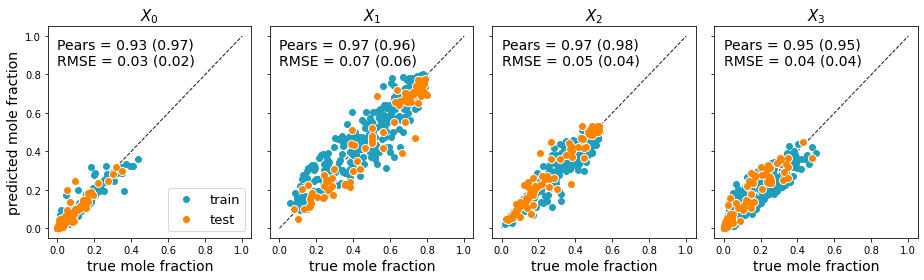

In [51]:
# make pairity plots with 
train_color = '#219ebc'
test_color  = '#fb8500'
outline = '#ffffff'



fig, axes = plt.subplots(1, 4, figsize=(13, 4), sharey=True)

# NA
axes[0].plot([0, 1], [0, 1], c='k', lw=1.0, ls='--', alpha=0.9)
# na training
axes[0].plot(train_true[:, 0], train_means[:, 0], c=outline, ls='', marker='o', markersize=8)
axes[0].plot(train_true[:, 0], train_means[:, 0], c=train_color, ls='', marker='o', markersize=6, label='train')
# na test
axes[0].plot(test_true[:, 0], test_means[:, 0], c=outline, ls='', marker='o', markersize=8)
axes[0].plot(test_true[:, 0], test_means[:, 0], c=test_color, ls='', marker='o', markersize=6, label='test')


# MA
axes[1].plot([0, 1], [0, 1], c='k', lw=1.0, ls='--', alpha=0.9)
# ma training
axes[1].plot(train_true[:, 1], train_means[:, 1], c=outline, ls='', marker='o', markersize=8)
axes[1].plot(train_true[:, 1], train_means[:, 1], c=train_color, ls='', marker='o', markersize=6, label='train')
# ma test
axes[1].plot(test_true[:, 1], test_means[:, 1], c=outline, ls='', marker='o', markersize=8)
axes[1].plot(test_true[:, 1], test_means[:, 1], c=test_color, ls='', marker='o', markersize=6, label='test')


# BA
axes[2].plot([0, 1], [0, 1], c='k', lw=1.0, ls='--', alpha=0.9)
# ba training
axes[2].plot(train_true[:, 2], train_means[:, 2], c=outline, ls='', marker='o', markersize=8)
axes[2].plot(train_true[:, 2], train_means[:, 2], c=train_color, ls='', marker='o', markersize=6, label='train')
# ba test
axes[2].plot(test_true[:, 2], test_means[:, 2], c=outline, ls='', marker='o', markersize=8)
axes[2].plot(test_true[:, 2], test_means[:, 2], c=test_color, ls='', marker='o', markersize=6, label='test')


# TA
axes[3].plot([0, 1], [0, 1], c='k', lw=1.0, ls='--', alpha=0.9)
# ta training
axes[3].plot(train_true[:, 3], train_means[:, 3], c=outline, ls='', marker='o', markersize=8)
axes[3].plot(train_true[:, 3], train_means[:, 3], c=train_color, ls='', marker='o', markersize=6, label='train')
# ta test
axes[3].plot(test_true[:, 3], test_means[:, 3], c=outline, ls='', marker='o', markersize=8)
axes[3].plot(test_true[:, 3], test_means[:, 3], c=test_color, ls='', marker='o', markersize=6, label='test')



axes[0].set_xlabel('true mole fraction', fontsize=14)
axes[1].set_xlabel('true mole fraction', fontsize=14)
axes[2].set_xlabel('true mole fraction', fontsize=14)
axes[3].set_xlabel('true mole fraction', fontsize=14)
axes[0].set_ylabel('predicted mole fraction', fontsize=14)

axes[0].set_title(r'$X_0$', fontsize=15)
axes[1].set_title(r'$X_1$', fontsize=15)
axes[2].set_title(r'$X_2$', fontsize=15)
axes[3].set_title(r'$X_3$', fontsize=15)

axes[0].legend(loc='lower right', fontsize=13)

na_train_pear = round(train_stats['na']['pear'], 2)
na_train_rmse = round(train_stats['na']['rmse'], 2)
na_test_pear = round(test_stats['na']['pear'], 2)
na_test_rmse = round(test_stats['na']['rmse'], 2)


ma_train_pear = round(train_stats['ma']['pear'], 2)
ma_train_rmse = round(train_stats['ma']['rmse'], 2)
ma_test_pear = round(test_stats['ma']['pear'], 2)
ma_test_rmse = round(test_stats['ma']['rmse'], 2)

ba_train_pear = round(train_stats['ba']['pear'], 2)
ba_train_rmse = round(train_stats['ba']['rmse'], 2)
ba_test_pear = round(test_stats['ba']['pear'], 2)
ba_test_rmse = round(test_stats['ba']['rmse'], 2)

ta_train_pear = round(train_stats['ta']['pear'], 2)
ta_train_rmse = round(train_stats['ta']['rmse'], 2)
ta_test_pear = round(test_stats['ta']['pear'], 2)
ta_test_rmse = round(test_stats['ta']['rmse'], 2)

axes[0].text(0.0, 0.85, s=f'Pears = {na_test_pear} ({na_train_pear})\nRMSE = {str(na_test_rmse)[:4]} ({str(na_train_rmse)[:4]})',
             fontsize=14)

axes[1].text(0.0, 0.85, s=f'Pears = {ma_test_pear} ({ma_train_pear})\nRMSE = {str(ma_test_rmse)[:4]} ({str(ma_train_rmse)[:4]})',
             fontsize=14)

axes[2].text(0.0, 0.85, s=f'Pears = {ba_test_pear} ({ba_train_pear})\nRMSE = {str(ba_test_rmse)[:4]} ({str(ba_train_rmse)[:4]})',
             fontsize=14)

axes[3].text(0.0, 0.85, s=f'Pears = {ta_test_pear} ({ta_train_pear})\nRMSE = {str(ta_test_rmse)[:4]} ({str(ta_train_rmse)[:4]})',
             fontsize=14)



plt.tight_layout()


In [54]:
pickle.dump(feature_scaler, open('torch_prod_models/feature_scaler.pkl', 'wb'))